In [ ]:
# Cell 1: Install and Import Libraries
!pip install -q earthengine-api geemap

import ee
import geemap
import pandas as pd
import numpy as np
from datetime import datetime

# Authenticate and Initialize Earth Engine
try:
    ee.Initialize(project='dojo-485716')
except:
    ee.Authenticate()
    ee.Initialize(project='dojo-485716')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00


In [ ]:
# Add this import at the top of your imports section
import os

In [ ]:
farmer_portfolio = {
    "George Mukama": [
        {
            "crop": "Maize", "size": 10,
            "coords": [[1.11739,33.90203], [1.11665,33.90119], [1.11615,33.90157], [1.11662,33.90255]]
        },
        {
            "crop": "Avocado", "size": 5,
            "coords": [[1.11726,33.9014], [1.11713,33.90152], [1.11688,33.90118], [1.11699,33.90109]]
        },
        {
            "crop": "Eucalyptus", "size": 15,
            "coords": [[1.117927,33.901234], [1.117563, 33.901470], [1.11716,33.90089], [1.11742,33.90071]]
        }
    ],
    "Tukule Samuel": [
        {
            "crop": "Coffee", "size": 4,
            "coords": [[1.078478, 33.884497], [1.079439, 33.884931], [1.080126, 33.884920], [1.079413, 33.885747]]
        },
        {
            "crop": "Cassava", "size": 1,
            "coords": [[1.08106,33.88796], [1.08084,33.88807], [1.08071,33.8878], [1.08095,33.88773]]
        },
        {
            "crop": "Maize", "size": 0.5,
            "coords": [[1.079965, 33.886170], [1.08003, 33.886905], [1.079590, 33.886916], [1.079568, 33.88615]]
        }
    ],
    "Emmanuel Gonahasa": [
        {
            "crop": "Avocado", "size": 5,
            "coords": [[1.05659,33.87743], [1.05638,33.87717], [1.05607,33.87747], [1.05619,33.8776]]
        },
        {
            "crop": "Eucalyptus", "size": 12,
            "coords": [[1.057428, 33.879250], [1.057396, 33.880495], [1.056655, 33.880527], [1.056022, 33.879218]]
        },
        {
            "crop": "Maize", "size": 5,
            "coords": [[1.054167, 33.880752], [1.052815, 33.880817], [1.052601, 33.882553], [1.053995, 33.882769]]
        }
    ],
    "Noah Natude": [
        {
            "crop": "Tomatoes", "size": 8,
            "coords": [
                [1.070147, 33.885127], [1.069056, 33.885576], [1.068861, 33.886234],
                [1.069517, 33.886981], [1.070826, 33.886032]
            ]
        },
        {
            "crop": "Rice", "size": 30,
            "coords": [
                [1.066624, 33.886600], [1.066857, 33.885685], [1.067888, 33.885577],
                [1.067928, 33.885910], [1.067411, 33.886023], [1.067481, 33.886364],
                [1.068000, 33.886237], [1.068149, 33.886648], [1.067708, 33.886846]
            ]
        },
        {
            "crop": "Groundnuts", "size": 8,
            "coords": [
                [1.070147, 33.885127], [1.069056, 33.885576], [1.068861, 33.886234],
                [1.069517, 33.886981], [1.070826, 33.886032]
            ]
        }
    ],
    "James Balya": [
        {
            "crop": "Oranges", "size": 2.5,
            "coords": [
                [0.982982, 33.857992], [0.982250, 33.858040],[0.982145, 33.858709], [0.983219, 33.858857], [0.983246, 33.858403], [0.982827, 33.858311]

            ]
        }
    ],
    "Cornelius Kaberwa": [
        {
            "crop": "Rice", "size": 3,
            "coords": [[1.117927, 33.901234], [1.117563, 33.901470], [1.117638, 33.900633], [1.117906, 33.901244]]
        }
    ]
}

In [ ]:
# Cell 3: Essential Helper Functions
def get_farm_geometry(coords):
    """Convert [Lat, Lon] list to EE Polygon [Lon, Lat]"""
    return ee.Geometry.Polygon([[p[1], p[0]] for p in coords])

In [ ]:
# Cell 4: Fixed Comprehensive Analysis Function with Time-Series Support
def get_comprehensive_farm_analysis(farmer_name, start_date="2024-12-01", end_date="2025-01-30",
                                   include_historical=False, step_days=10):
    """
    Generate comprehensive analysis for a specific farmer with optional historical time-series.

    Parameters:
    -----------
    farmer_name : str
        Name of the farmer from portfolio
    start_date : str
        Start date for analysis (YYYY-MM-DD)
    end_date : str
        End date for analysis (YYYY-MM-DD)
    include_historical : bool
        If True, includes time-series analysis (like extract_high_res_historical)
    step_days : int
        Step size in days for time-series analysis (only used if include_historical=True)

    Returns:
    --------
    tuple: (current_df, historical_df, current_filename, historical_filename)
           or (current_df, None, current_filename, None) if include_historical=False
    """

    if farmer_name not in farmer_portfolio:
        print(f"❌ Farmer '{farmer_name}' not found in portfolio.")
        return pd.DataFrame(), None, None, None

    print(f"🌱 Starting Comprehensive Analysis for {farmer_name}...")
    print(f"📅 Period: {start_date} to {end_date}")
    if include_historical:
        print(f"📈 Including historical time-series analysis (step: {step_days} days)")
    print("=" * 60)

    # Initialize results lists
    current_results = []
    historical_results = [] if include_historical else None

    # Get unique parcels
    unique_parcels = {}
    for farm in farmer_portfolio[farmer_name]:
        coord_tuple = tuple(tuple(c) for c in farm['coords'])
        if coord_tuple not in unique_parcels:
            unique_parcels[coord_tuple] = {
                'crops': [farm['crop']],
                'size_reported': farm['size'],
                'coords': farm['coords']  # Store original coords
            }
        else:
            if farm['crop'] not in unique_parcels[coord_tuple]['crops']:
                unique_parcels[coord_tuple]['crops'].append(farm['crop'])

    # Process each parcel for CURRENT analysis
    parcel_idx = 1
    for coords_key, info in unique_parcels.items():
        # Setup geometry
        poly = get_farm_geometry(info['coords'])
        crops_str = " & ".join(info['crops'])

        print(f"\n📍 Processing Parcel {parcel_idx} for CURRENT analysis: {crops_str}")

        # Get date range for current analysis
        start_ee = ee.Date(start_date)
        end_ee = ee.Date(end_date)

        # CURRENT ANALYSIS: Get Satellite Imagery (Sentinel-2)
        s2_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(poly)
                  .filterDate(start_ee, end_ee)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40)))

        # Check if we have data
        s2_size = s2_coll.size().getInfo()
        if s2_size == 0:
            print(f"   ⚠️ No satellite data available for this period")
            parcel_idx += 1
            continue

        # Use median composite
        s2_median = s2_coll.median()

        # Calculate indices
        ndvi = s2_median.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndwi = s2_median.normalizedDifference(['B8', 'B11']).rename('NDWI')
        bsi = s2_median.expression(
            '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
            {
                'B11': s2_median.select('B11'),
                'B8': s2_median.select('B8'),
                'B4': s2_median.select('B4'),
                'B2': s2_median.select('B2')
            }
        ).rename('BSI')

        # Extract index values
        ndvi_stats = ndvi.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo()
        ndwi_stats = ndwi.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo()
        bsi_stats = bsi.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo()

        ndvi_val = ndvi_stats.get('NDVI')
        ndwi_val = ndwi_stats.get('NDWI')
        bsi_val = bsi_stats.get('BSI')

        # Rainfall Analysis (CHIRPS)
        rain_coll = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                    .filterBounds(poly)
                    .filterDate(start_ee, end_ee))

        rain_sum = rain_coll.sum()
        rain_stats = rain_sum.reduceRegion(ee.Reducer.mean(), poly, 5000).getInfo()
        rain_val = rain_stats.get('precipitation') if rain_stats else None

        # Rainfall Status
        if rain_val is not None:
            if rain_val < 60:
                rain_status = "🚨 SEVERE DROUGHT"
            elif rain_val < 100:
                rain_status = "⚠️ MILD STRESS"
            elif rain_val > 250:
                rain_status = "🌊 FLOOD RISK"
            else:
                rain_status = "✅ OPTIMAL"
            rain_display = f"{rain_val:.1f}mm"
        else:
            rain_status = "❓ DATA UNAVAILABLE"
            rain_display = "N/A"

        # Soil Moisture (Sentinel-1 Radar)
        try:
            s1_coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
                      .filterBounds(poly)
                      .filterDate(start_ee, end_ee)
                      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')))

            if s1_coll.size().getInfo() > 0:
                s1_median = s1_coll.median()
                vv_stats = s1_median.select('VV').reduceRegion(ee.Reducer.mean(), poly, 10).getInfo()
                vv_val = vv_stats.get('VV') if vv_stats else None

                if vv_val is not None:
                    if vv_val < -15:
                        soil_moisture_status = "🚨 EXTREMELY DRY"
                    elif vv_val < -10:
                        soil_moisture_status = "⚠️ MODERATELY DRY"
                    else:
                        soil_moisture_status = "💧 ADEQUATE"
                else:
                    vv_val = None
                    soil_moisture_status = "❓ NO RADAR DATA"
            else:
                vv_val = None
                soil_moisture_status = "❓ NO RADAR DATA"
        except Exception as e:
            vv_val = None
            soil_moisture_status = "❓ RADAR DATA UNAVAILABLE"

        # Disease/Pest Risk Assessment
        disease_risk = "✅ STABLE"
        if ndwi_val is not None and rain_val is not None:
            if ndwi_val < 0.1 and rain_val < 20:
                disease_risk = "🔴 HIGH PEST RISK (Aphids/Mites)"
            elif ndwi_val > 0.4 and rain_val > 100:
                disease_risk = "🟠 HIGH FUNGAL RISK (Blight/Rust)"
        elif ndwi_val is None or rain_val is None:
            disease_risk = "❓ INSUFFICIENT DATA"

        # Temperature & Humidity (using ERA5-Land reanalysis data)
        try:
            era5_coll = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
                        .filterBounds(poly)
                        .filterDate(start_ee, end_ee))

            if era5_coll.size().getInfo() > 0:
                era5_mean = era5_coll.mean()

                # Temperature
                temp_stats = era5_mean.select('temperature_2m').reduceRegion(
                    ee.Reducer.mean(), poly, 10000).getInfo()
                temp_k = temp_stats.get('temperature_2m') if temp_stats else None

                if temp_k:
                    temp_c = temp_k - 273.15
                    temp_status = f"{temp_c:.1f}°C"
                else:
                    temp_c = None
                    temp_status = "❓ DATA UNAVAILABLE"

                # Humidity
                dewpoint_stats = era5_mean.select('dewpoint_temperature_2m').reduceRegion(
                    ee.Reducer.mean(), poly, 10000).getInfo()
                dewpoint_k = dewpoint_stats.get('dewpoint_temperature_2m') if dewpoint_stats else None

                if dewpoint_k and temp_k:
                    dewpoint_c = dewpoint_k - 273.15
                    rh = 100 * (np.exp((17.625 * dewpoint_c)/(243.04 + dewpoint_c)) /
                               np.exp((17.625 * temp_c)/(243.04 + temp_c)))
                    humidity_status = f"{rh:.1f}%"
                else:
                    humidity_status = "❓ DATA UNAVAILABLE"
            else:
                temp_status = "❓ DATA UNAVAILABLE"
                humidity_status = "❓ DATA UNAVAILABLE"
        except Exception as e:
            temp_status = "❓ DATA UNAVAILABLE"
            humidity_status = "❓ DATA UNAVAILABLE"

        # Anomaly Detection (Historical Comparison)
        try:
            current_ndvi = ndvi_val
            if current_ndvi is not None:
                hist_start = ee.Date(start_date).advance(-3, 'year')
                hist_end = ee.Date(end_date).advance(-3, 'year')

                hist_s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                          .filterBounds(poly)
                          .filterDate(hist_start, hist_end)
                          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40))
                          .median())

                hist_ndvi = hist_s2.normalizedDifference(['B8', 'B4'])
                hist_ndvi_val = hist_ndvi.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo().get('nd')

                if hist_ndvi_val is not None:
                    diff_ratio = current_ndvi / hist_ndvi_val if hist_ndvi_val != 0 else 1
                    if diff_ratio < 0.8:
                        anomaly_status = f"🚨 {((1-diff_ratio)*100):.1f}% BELOW HISTORICAL"
                    elif diff_ratio > 1.2:
                        anomaly_status = f"📈 {((diff_ratio-1)*100):.1f}% ABOVE HISTORICAL"
                    else:
                        anomaly_status = "📊 WITHIN NORMAL RANGE"
                else:
                    anomaly_status = "❓ CANNOT COMPARE"
            else:
                anomaly_status = "❓ CANNOT COMPARE"
        except Exception as e:
            anomaly_status = "❓ HISTORICAL DATA UNAVAILABLE"

        # Calculate area
        area_acres = poly.area().divide(4046.86).getInfo()

        # Create current result entry
        current_result = {
            'Farmer_Name': farmer_name,
            'Parcel_ID': f"Parcel_{parcel_idx}",
            'Crops': crops_str,
            'Reported_Size_Acres': info['size_reported'],
            'Calculated_Size_Acres': round(area_acres, 2) if area_acres else None,
            'Analysis_Period': f"{start_date} to {end_date}",
            'NDVI': round(ndvi_val, 3) if ndvi_val is not None else None,
            'NDWI': round(ndwi_val, 3) if ndwi_val is not None else None,
            'BSI': round(bsi_val, 3) if bsi_val is not None else None,
            'Total_Rainfall_mm': round(rain_val, 1) if rain_val is not None else None,
            'Rainfall_Status': rain_status,
            'Soil_Moisture_VV': round(vv_val, 2) if vv_val is not None else None,
            'Soil_Moisture_Status': soil_moisture_status,
            'Disease_Pest_Risk': disease_risk,
            'Temperature': temp_status,
            'Humidity': humidity_status,
            'Health_Anomaly': anomaly_status,
            'Data_Retrieval_Date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        current_results.append(current_result)

        # Print summary for this parcel
        ndvi_display = f"{ndvi_val:.3f}" if ndvi_val is not None else "N/A"
        print(f"   ✅ NDVI: {ndvi_display} | Rainfall: {rain_display}")
        print(f"   💧 Soil: {soil_moisture_status} | Risk: {disease_risk}")

        # HISTORICAL TIME-SERIES ANALYSIS (if requested)
        if include_historical:
            print(f"   📊 Generating historical time-series for {crops_str}...")

            # Generate date series for historical analysis
            # Use a wider historical range (2020-2024) for comprehensive time-series
            hist_start_py = pd.Timestamp('2020-01-01')
            hist_end_py = pd.Timestamp(end_date)  # End at current analysis end date
            date_series = pd.date_range(start=hist_start_py, end=hist_end_py, freq=f'{step_days}D')

            for crop in info['crops']:
                periods_processed = 0
                for i in range(len(date_series) - 1):
                    p_start_py = date_series[i]
                    p_end_py = date_series[i+1]
                    date_label = p_start_py.strftime('%Y-%m-%d')
                    p_start_ee = ee.Date(date_label)
                    p_end_ee = ee.Date(p_end_py.strftime('%Y-%m-%d'))

                    # Get NDVI for this time period
                    ndvi_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                                .filterBounds(poly)
                                .filterDate(p_start_ee, p_end_ee)
                                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))

                    ndvi_val_hist = None
                    if ndvi_coll.size().getInfo() > 0:
                        ndvi_img = ndvi_coll.median().normalizedDifference(['B8', 'B4'])
                        stats = ndvi_img.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo()
                        ndvi_val_hist = stats.get('nd')

                    # Get rainfall for this time period
                    rain_img = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                               .filterBounds(poly)
                               .filterDate(p_start_ee, p_end_ee)
                               .sum())

                    rain_stats = rain_img.reduceRegion(ee.Reducer.mean(), poly, 5000).getInfo()
                    rain_val_hist = rain_stats.get('precipitation') if rain_stats else None

                    # Only add to results if we have at least one data point
                    if ndvi_val_hist is not None or rain_val_hist is not None:
                        historical_results.append({
                            'Farmer': farmer_name,
                            'Parcel_ID': f"Parcel_{parcel_idx}",
                            'Crop': crop,
                            'Start_Date': date_label,
                            'End_Date': p_end_py.strftime('%Y-%m-%d'),
                            'NDVI_Health': ndvi_val_hist,
                            'Rainfall_mm': rain_val_hist,
                            'Period_Days': step_days
                        })
                        periods_processed += 1

                print(f"     ✅ Historical data generated for {crop} ({periods_processed} periods with data)")

        parcel_idx += 1

    # Create DataFrames
    current_df = pd.DataFrame(current_results) if current_results else pd.DataFrame()
    historical_df = pd.DataFrame(historical_results) if include_historical and historical_results else None

    # Save to CSV files
    if not current_df.empty:
        # Current analysis filename
        current_filename = f"{farmer_name.replace(' ', '_')}_Current_Analysis_{start_date.replace('-', '')}_{end_date.replace('-', '')}.csv"
        current_df.to_csv(current_filename, index=False)

        # Historical filename (if historical data was generated)
        if include_historical and historical_df is not None and not historical_df.empty:
            historical_filename = f"{farmer_name.replace(' ', '_')}_Historical_TimeSeries_{step_days}day_step.csv"
            historical_df.to_csv(historical_filename, index=False)
            print(f"\n✅ Analysis complete! Files saved:")
            print(f"   📋 Current Analysis: {current_filename}")
            print(f"   📊 Historical Time-Series: {historical_filename}")
        else:
            historical_filename = None
            if include_historical:
                print(f"\n✅ Current analysis complete! No historical data found.")
                print(f"   📋 Current Analysis: {current_filename}")
            else:
                print(f"\n✅ Analysis complete! File saved: {current_filename}")

        # Display summary
        if not current_df.empty:
            print("\n📊 CURRENT ANALYSIS SUMMARY:")
            print("=" * 100)
            summary_df = current_df[['Parcel_ID', 'Crops', 'NDVI', 'Total_Rainfall_mm',
                                    'Rainfall_Status', 'Soil_Moisture_Status', 'Disease_Pest_Risk']].copy()
            print(summary_df.to_string(index=False))

        if include_historical and historical_df is not None and not historical_df.empty:
            print("\n📈 HISTORICAL TIME-SERIES SUMMARY:")
            print(f"   Total time-series records: {len(historical_df)}")
            print(f"   Time period: {historical_df['Start_Date'].min()} to {historical_df['Start_Date'].max()}")
            print(f"   Number of crops tracked: {historical_df['Crop'].nunique()}")

        return current_df, historical_df, current_filename, historical_filename
    else:
        print("❌ No data could be retrieved for this farmer.")
        return pd.DataFrame(), None, None, None

In [ ]:
# Cell 5: Existing Functions (Keep these)
def analyze_complete_farmer_holdings(farmer_name, start_date, end_date, grid_size=20):
    """For detailed map-based analysis - KEEP THIS FUNCTION"""
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."

    print(f"📊 Starting Full Analysis for {farmer_name}...")
    Map = geemap.Map()

    all_records = []
    unique_parcels = {}

    for farm in farmer_portfolio[farmer_name]:
        coord_tuple = tuple(tuple(c) for c in farm['coords'])
        if coord_tuple not in unique_parcels:
            unique_parcels[coord_tuple] = {'crops': [farm['crop']], 'size_reported': farm['size']}
        else:
            if farm['crop'] not in unique_parcels[coord_tuple]['crops']:
                unique_parcels[coord_tuple]['crops'].append(farm['crop'])

    all_geoms = []
    parcel_idx = 1

    for coords, info in unique_parcels.items():
        poly = get_farm_geometry(list(coords))
        all_geoms.append(ee.Feature(poly))

        area_acres = poly.area().divide(4046.86).getInfo()
        crops_str = " & ".join(info['crops'])
        print(f"📍 Parcel {parcel_idx}: {crops_str} | Calculated Area: {area_acres:.2f} Acres")

        grid = poly.coveringGrid(poly.projection(), grid_size).filterBounds(poly)

        s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(poly).filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40))
              .median())

        if s2.bandNames().size().getInfo() > 0:
            ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
            ndwi = s2.normalizedDifference(['B8', 'B11']).rename('NDWI')
            bsi = s2.expression('((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
                               {'B11': s2.select('B11'), 'B8': s2.select('B8'),
                                'B4': s2.select('B4'), 'B2': s2.select('B2')}).rename('BSI')

            combined = ee.Image.cat([ndvi, ndwi, bsi])

            rain = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                   .filterBounds(poly).filterDate(start_date, end_date)
                   .sum().reduceRegion(ee.Reducer.mean(), poly, 5000).getInfo().get('precipitation'))

            stats = combined.reduceRegions(collection=grid, reducer=ee.Reducer.mean(), scale=10).getInfo()
            for feature in stats['features']:
                results = feature['properties']
                all_records.append({
                    'Farmer': farmer_name,
                    'Parcel_ID': f"Farm_{parcel_idx}",
                    'Crops': crops_str,
                    'Acreage': round(area_acres, 2),
                    'NDVI_Health': results.get('NDVI'),
                    'NDWI_Water': results.get('NDWI'),
                    'BSI_Soil': results.get('BSI'),
                    'Period_Rain_mm': rain
                })

            ndvi_vis = {'min': 0, 'max': 0.8, 'palette': ['#d73027', '#f46d43', '#fee08b', '#d9ef8b', '#1a9850']}
            Map.addLayer(ndvi.clip(poly), ndvi_vis, f"Health: {crops_str}")
            Map.addLayer(ee.Image().paint(poly, 0, 2), {'palette': 'white'}, f"Boundary: Farm {parcel_idx}")

        parcel_idx += 1

    legend_dict = {
        'Excellent Health (High NDVI)': '#1a9850',
        'Good Health': '#a6d96a',
        'Moderate/Stressed': '#fee08b',
        'Poor/Bare Soil': '#d73027',
        'Farm Boundary': '#ffffff'
    }
    Map.add_legend(title=f"Legend: {farmer_name}'s Farms", legend_dict=legend_dict)
    Map.centerObject(ee.FeatureCollection(all_geoms), 15)

    return pd.DataFrame(all_records), Map


def extract_high_res_historical(farmer_name, step_days=10):
    """For time-series analysis - KEEP THIS FUNCTION"""
    if farmer_name not in farmer_portfolio:
        return None

    print(f"⌛ Processing Calendar-Correct Timeline for {farmer_name}...")
    results = []

    date_series = pd.date_range(start='2020-01-01', end='2025-01-01', freq=f'{step_days}D')

    for farm in farmer_portfolio[farmer_name]:
        crop = farm['crop']
        poly_coords = [[p[1], p[0]] for p in farm['coords']]
        geom = ee.Geometry.Polygon(poly_coords)

        for i in range(len(date_series) - 1):
            p_start_py = date_series[i]
            p_end_py = date_series[i+1]
            date_label = p_start_py.strftime('%Y-%m-%d')
            p_start_ee = ee.Date(date_label)
            p_end_ee = ee.Date(p_end_py.strftime('%Y-%m-%d'))

            ndvi_coll = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(geom)
                      .filterDate(p_start_ee, p_end_ee)
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))

            ndvi_val = None
            if ndvi_coll.size().getInfo() > 0:
                ndvi_img = ndvi_coll.median().normalizedDifference(['B8', 'B4'])
                stats = ndvi_img.reduceRegion(ee.Reducer.mean(), geom, 10).getInfo()
                ndvi_val = stats.get('nd')

            rain_img = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                       .filterBounds(geom)
                       .filterDate(p_start_ee, p_end_ee)
                       .sum())

            rain_stats = rain_img.reduceRegion(ee.Reducer.mean(), geom, 5000).getInfo()
            rain_val = rain_stats.get('precipitation')

            results.append({
                'Farmer': farmer_name,
                'Crop': crop,
                'Start_Date': date_label,
                'NDVI_Health': ndvi_val,
                'Rainfall_mm': rain_val
            })

        print(f"  ✅ Completed {crop}")

    return pd.DataFrame(results)


def generate_daily_scouting_snapshot(farmer_name, target_date, grid_size=30):
    """For specific date analysis - KEEP THIS FUNCTION"""
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."

    date_obj = ee.Date(target_date)
    start_search = date_obj.advance(-5, 'day')
    end_search = date_obj.advance(1, 'day')

    seen_coords = set()
    parcels = [f for f in farmer_portfolio[farmer_name] if not (tuple(tuple(c) for c in f['coords']) in seen_coords or seen_coords.add(tuple(tuple(c) for c in f['coords'])))]

    for idx, parcel in enumerate(parcels):
        poly = get_farm_geometry(parcel['coords'])

        s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                        .filterBounds(poly)
                        .filterDate(start_search, end_search)
                        .sort('CLOUDY_PIXEL_PERCENTAGE'))

        image_count = s2_collection.size().getInfo()

        if image_count == 0:
            print(f"❌ No satellite data found for {farmer_name} near {target_date}. Try a different date.")
            continue

        best_image = ee.Image(s2_collection.first())
        actual_date = ee.Date(best_image.get('system:time_start')).format('YYYY-MM-DD').getInfo()
        cloud_pct = best_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()

        print(f"\n{'='*60}")
        print(f"📸 SNAPSHOT REPORT: {farmer_name} | FARM {idx+1}")
        print(f"📅 Requested: {target_date} | 🛰️ Found Image: {actual_date}")
        print(f"☁️ Cloud Cover: {cloud_pct:.1f}%")
        print(f"{'='*60}")

        ndvi = best_image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndwi = best_image.normalizedDifference(['B8', 'B11']).rename('NDWI')
        bsi = best_image.expression('((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
                                   {'B11': best_image.select('B11'), 'B8': best_image.select('B8'),
                                    'B4': best_image.select('B4'), 'B2': best_image.select('B2')}).rename('BSI')

        grid = poly.coveringGrid(poly.projection(), grid_size).filterBounds(poly)

        m = geemap.Map()
        m.centerObject(poly, 18)
        m.addLayer(ndvi.clip(poly), {'min': 0.1, 'max': 0.8, 'palette': ['red', 'yellow', 'green']}, 'Health (NDVI)')
        m.addLayer(ndwi.clip(poly), {'min': -0.1, 'max': 0.5, 'palette': ['brown', 'yellow', 'blue']}, 'Water (NDWI)')
        m.addLayer(grid, {'color': 'white'}, 'Scouting Grid')
        m.add_text(f"Snapshot: {actual_date}", position='topright')

        display(m)

EXAMPLE 1: Current Analysis Only
🌱 Starting Comprehensive Analysis for Noah Natude...
📅 Period: 2024-12-01 to 2025-01-30

📍 Processing Parcel 1 for CURRENT analysis: Tomatoes & Groundnuts
   ✅ NDVI: 0.496 | Rainfall: 69.7mm
   💧 Soil: ⚠️ MODERATELY DRY | Risk: ✅ STABLE

📍 Processing Parcel 2 for CURRENT analysis: Rice
   ✅ NDVI: 0.481 | Rainfall: N/A
   💧 Soil: 💧 ADEQUATE | Risk: ❓ INSUFFICIENT DATA

✅ Analysis complete! File saved: Noah_Natude_Current_Analysis_20241201_20250130.csv

📊 CURRENT ANALYSIS SUMMARY:
Parcel_ID                 Crops  NDVI  Total_Rainfall_mm    Rainfall_Status Soil_Moisture_Status   Disease_Pest_Risk
 Parcel_1 Tomatoes & Groundnuts 0.496               69.7     ⚠️ MILD STRESS    ⚠️ MODERATELY DRY            ✅ STABLE
 Parcel_2                  Rice 0.481                NaN ❓ DATA UNAVAILABLE           💧 ADEQUATE ❓ INSUFFICIENT DATA


EXAMPLE 2: Current + Historical Analysis
🌱 Starting Comprehensive Analysis for George Mukama...
📅 Period: 2024-12-01 to 2025-01-30

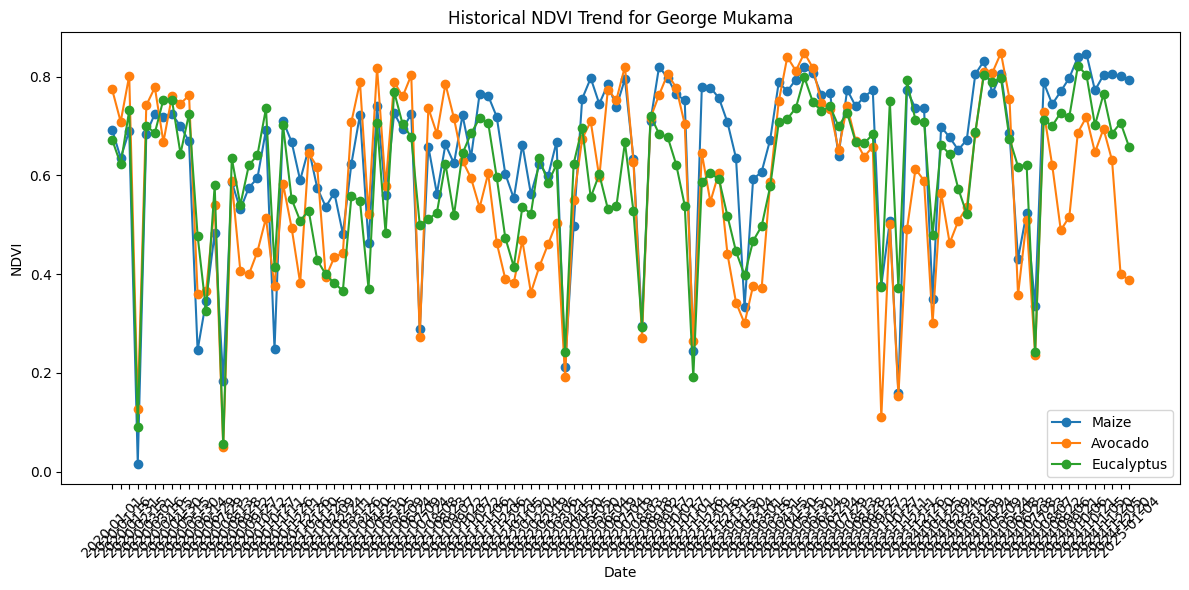



EXAMPLE 3: Batch Analysis with Historical Data

📊 Analyzing George Mukama...
🌱 Starting Comprehensive Analysis for George Mukama...
📅 Period: 2024-12-01 to 2025-01-30
📈 Including historical time-series analysis (step: 30 days)

📍 Processing Parcel 1 for CURRENT analysis: Maize
   ✅ NDVI: 0.799 | Rainfall: N/A
   💧 Soil: 💧 ADEQUATE | Risk: ❓ INSUFFICIENT DATA
   📊 Generating historical time-series for Maize...
     ✅ Historical data generated for Maize (61 periods with data)

📍 Processing Parcel 2 for CURRENT analysis: Avocado
   ✅ NDVI: 0.462 | Rainfall: N/A
   💧 Soil: ⚠️ MODERATELY DRY | Risk: ❓ INSUFFICIENT DATA
   📊 Generating historical time-series for Avocado...
     ✅ Historical data generated for Avocado (61 periods with data)

📍 Processing Parcel 3 for CURRENT analysis: Eucalyptus
   ✅ NDVI: 0.695 | Rainfall: N/A
   💧 Soil: 💧 ADEQUATE | Risk: ❓ INSUFFICIENT DATA
   📊 Generating historical time-series for Eucalyptus...
     ✅ Historical data generated for Eucalyptus (61 period

In [ ]:
# Cell 6: Example Usage of the Merged Function

# Example 1: Current analysis only (like the old comprehensive function)
print("EXAMPLE 1: Current Analysis Only")
print("=" * 80)

noah_current_df, _, noah_current_file, _ = get_comprehensive_farm_analysis(
    farmer_name="Noah Natude",
    start_date="2024-12-01",
    end_date="2025-01-30",
    include_historical=False  # Just current analysis
)

# Example 2: Current + Historical analysis (both in one call)
print("\n\nEXAMPLE 2: Current + Historical Analysis")
print("=" * 80)

george_current_df, george_historical_df, george_current_file, george_historical_file = get_comprehensive_farm_analysis(
    farmer_name="George Mukama",
    start_date="2024-12-01",
    end_date="2025-01-30",
    include_historical=True,  # Get both current and historical
    step_days=15  # 15-day intervals for historical data
)

if george_historical_df is not None:
    print(f"\n📊 Historical data preview:")
    print(george_historical_df.head())

    # Plot historical NDVI trend
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    for crop in george_historical_df['Crop'].unique():
        crop_data = george_historical_df[george_historical_df['Crop'] == crop]
        crop_data = crop_data.sort_values('Start_Date')
        plt.plot(crop_data['Start_Date'], crop_data['NDVI_Health'], marker='o', label=crop)

    plt.title(f"Historical NDVI Trend for George Mukama")
    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example 3: Batch analysis for all farmers with historical data
print("\n\nEXAMPLE 3: Batch Analysis with Historical Data")
print("=" * 80)

all_farmers_current = {}
all_farmers_historical = {}

for farmer_name in list(farmer_portfolio.keys())[:3]:  # First 3 farmers as example
    print(f"\n📊 Analyzing {farmer_name}...")
    current_df, historical_df, current_file, historical_file = get_comprehensive_farm_analysis(
        farmer_name=farmer_name,
        start_date="2024-12-01",
        end_date="2025-01-30",
        include_historical=True,
        step_days=30  # Monthly intervals
    )

    if not current_df.empty:
        all_farmers_current[farmer_name] = current_df
        all_farmers_historical[farmer_name] = historical_df

# Combine all current data
if all_farmers_current:
    master_current_df = pd.concat(all_farmers_current.values(), ignore_index=True)
    master_current_df.to_csv("ALL_FARMERS_CURRENT_ANALYSIS.csv", index=False)
    print(f"\n✅ Master current analysis file created")

# Combine all historical data
if all_farmers_historical:
    master_historical_df = pd.concat(all_farmers_historical.values(), ignore_index=True)
    master_historical_df.to_csv("ALL_FARMERS_HISTORICAL_ANALYSIS.csv", index=False)
    print(f"✅ Master historical analysis file created")

In [ ]:
# Cell 7: Additional Utility Functions

def view_analysis_results(farmer_name):
    """View the CSV file created by comprehensive analysis"""
    filename = f"{farmer_name.replace(' ', '_')}_Comprehensive_Analysis_20241201_20250130.csv"
    try:
        df = pd.read_csv(filename)
        print(f"📊 Analysis Results for {farmer_name}:")
        print("=" * 100)
        print(df.to_string(index=False))
        return df
    except FileNotFoundError:
        print(f"❌ File not found. Run analysis first using get_comprehensive_farm_analysis()")
        return None

def compare_farmers(farmer1, farmer2):
    """Compare two farmers' analysis results"""
    print(f"🔄 COMPARING {farmer1} vs {farmer2}")
    print("=" * 80)

    df1, _ = get_comprehensive_farm_analysis(farmer1)
    df2, _ = get_comprehensive_farm_analysis(farmer2)

    if not df1.empty and not df2.empty:
        print("\n📈 AVERAGE NDVI COMPARISON:")
        print(f"{farmer1}: {df1['NDVI'].mean():.3f}")
        print(f"{farmer2}: {df2['NDVI'].mean():.3f}")

        print("\n🌧️ RAINFALL COMPARISON:")
        print(f"{farmer1}: {df1['Total_Rainfall_mm'].mean():.1f} mm")
        print(f"{farmer2}: {df2['Total_Rainfall_mm'].mean():.1f} mm")

        print("\n⚠️ RISK STATUS:")
        print(f"{farmer1}: {df1['Disease_Pest_Risk'].iloc[0]}")
        print(f"{farmer2}: {df2['Disease_Pest_Risk'].iloc[0]}")

# Quick usage examples in notebook:
# 1. Get comprehensive analysis: df, filename = get_comprehensive_farm_analysis("Noah Natude")
# 2. View results: view_analysis_results("Noah Natude")
# 3. Compare farmers: compare_farmers("Noah Natude", "George Mukama")

In [ ]:
# This will show Noah's Rice (30 acres) and his combined Tomato/Groundnut plot (8 acres)
tukule_results_df, tukule_map = analyze_complete_farmer_holdings("Tukule Samuel", "2024-12-01", "2025-01-30")

# Show the interactive map
tukule_map

📊 Starting Full Analysis for Tukule Samuel...
📍 Parcel 1: Coffee | Calculated Area: 2.07 Acres
📍 Parcel 2: Cassava | Calculated Area: 0.21 Acres
📍 Parcel 3: Maize | Calculated Area: 0.96 Acres


Map(center=[1.0795701722859952, 33.88571740908405], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:

george_results_df, george_map = analyze_complete_farmer_holdings("George Mukama", "2024-12-01", "2025-01-30")
george_map

📊 Starting Full Analysis for George Mukama...
📍 Parcel 1: Maize | Calculated Area: 2.60 Acres
📍 Parcel 2: Avocado | Calculated Area: 0.20 Acres
📍 Parcel 3: Eucalyptus | Calculated Area: 0.82 Acres


Map(center=[1.1169251522395913, 33.9016573462067], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
def generate_daily_scouting_snapshot(farmer_name, target_date, grid_size=30):
    if farmer_name not in farmer_portfolio:
        return "Farmer not found."

    # Convert string date to EE date
    date_obj = ee.Date(target_date)

    # Define a search window (Target Date minus 5 days)
    # This ensures we catch the most recent satellite pass
    start_search = date_obj.advance(-5, 'day')
    end_search = date_obj.advance(1, 'day')

    # Identify Unique Land Parcels
    seen_coords = set()
    parcels = [f for f in farmer_portfolio[farmer_name] if not (tuple(tuple(c) for c in f['coords']) in seen_coords or seen_coords.add(tuple(tuple(c) for c in f['coords'])))]

    for idx, parcel in enumerate(parcels):
        poly = get_farm_geometry(parcel['coords'])

        # 1. FIND THE SPECIFIC IMAGE
        # We sort by 'CLOUD_COVER' so if there are two passes, we get the clearest one
        s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                        .filterBounds(poly)
                        .filterDate(start_search, end_search)
                        .sort('CLOUDY_PIXEL_PERCENTAGE'))

        image_count = s2_collection.size().getInfo()

        if image_count == 0:
            print(f"❌ No satellite data found for {farmer_name} near {target_date}. Try a different date.")
            continue

        # Pick the best single image from that window
        best_image = ee.Image(s2_collection.first())
        actual_date = ee.Date(best_image.get('system:time_start')).format('YYYY-MM-DD').getInfo()
        cloud_pct = best_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()

        print(f"\n{'='*60}")
        print(f"📸 SNAPSHOT REPORT: {farmer_name} | FARM {idx+1}")
        print(f"📅 Requested: {target_date} | 🛰️ Found Image: {actual_date}")
        print(f"☁️ Cloud Cover: {cloud_pct:.1f}%")
        print(f"{'='*60}")

        # Calculate Indices
        ndvi = best_image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndwi = best_image.normalizedDifference(['B8', 'B11']).rename('NDWI')
        bsi = best_image.expression('((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))',
                                   {'B11': best_image.select('B11'), 'B8': best_image.select('B8'),
                                    'B4': best_image.select('B4'), 'B2': best_image.select('B2')}).rename('BSI')

        # Create Numbered Grid
        grid = poly.coveringGrid(poly.projection(), grid_size).filterBounds(poly)

        # Generate Maps (Showing NDVI as example - you can repeat for NDWI/BSI)
        m = geemap.Map()
        m.centerObject(poly, 18)

        # Add the Indices
        m.addLayer(ndvi.clip(poly), {'min': 0.1, 'max': 0.8, 'palette': ['red', 'yellow', 'green']}, 'Health (NDVI)')
        m.addLayer(ndwi.clip(poly), {'min': -0.1, 'max': 0.5, 'palette': ['brown', 'yellow', 'blue']}, 'Water (NDWI)')

        # Add the Scouting Grid
        m.addLayer(grid, {'color': 'white'}, 'Scouting Grid')

        # Add Labels to identify the date clearly on the map
        m.add_text(f"Snapshot: {actual_date}", position='topright')

        display(m)

# --- EXECUTION ---
# Example: Look for an image on Christmas Day 2024
generate_daily_scouting_snapshot("Noah Natude", "2024-12-25")


📸 SNAPSHOT REPORT: Noah Natude | FARM 1
📅 Requested: 2024-12-25 | 🛰️ Found Image: 2024-12-359
☁️ Cloud Cover: 66.8%


Map(center=[1.0697739145988707, 33.88601309851582], controls=(WidgetControl(options=['position', 'transparent_…


📸 SNAPSHOT REPORT: Noah Natude | FARM 2
📅 Requested: 2024-12-25 | 🛰️ Found Image: 2024-12-359
☁️ Cloud Cover: 66.8%


Map(center=[1.0673494746803012, 33.88623534364259], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Cell 6: Display Functions for Output DataFrames

def display_current_analysis(df, farmer_name=None, show_all=False):
    """
    Display the current analysis DataFrame with nice formatting.

    Parameters:
    -----------
    df : pandas.DataFrame
        Current analysis DataFrame from get_comprehensive_farm_analysis
    farmer_name : str, optional
        Name of the farmer (for title)
    show_all : bool
        If True, shows all columns. If False, shows key columns only.
    """
    if df.empty:
        print("❌ No data to display")
        return

    # Create a styled DataFrame
    display_df = df.copy()

    # Format numeric columns
    numeric_cols = ['NDVI', 'NDWI', 'BSI', 'Total_Rainfall_mm', 'Calculated_Size_Acres']
    for col in numeric_cols:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")

    # Add title
    if farmer_name:
        print(f"\n📊 CURRENT ANALYSIS FOR: {farmer_name}")
    else:
        print(f"\n📊 CURRENT ANALYSIS")
    print("=" * 120)

    if show_all:
        # Show all columns
        print(display_df.to_string(index=False))
    else:
        # Show key columns with emphasis
        key_columns = ['Parcel_ID', 'Crops', 'NDVI', 'Total_Rainfall_mm',
                      'Rainfall_Status', 'Soil_Moisture_Status', 'Disease_Pest_Risk']

        # Filter to available columns
        available_columns = [col for col in key_columns if col in display_df.columns]
        print(display_df[available_columns].to_string(index=False))

        # Show summary statistics
        print("\n📈 SUMMARY STATISTICS:")
        print("-" * 60)

        if 'NDVI' in df.columns:
            ndvi_mean = df['NDVI'].mean()
            ndvi_status = "✅ Healthy" if ndvi_mean > 0.5 else "⚠️ Moderate" if ndvi_mean > 0.3 else "❌ Poor"
            print(f"Average NDVI: {ndvi_mean:.3f} ({ndvi_status})")

        if 'Total_Rainfall_mm' in df.columns:
            rain_total = df['Total_Rainfall_mm'].sum()
            print(f"Total Rainfall: {rain_total:.1f} mm")

        if 'Disease_Pest_Risk' in df.columns:
            risks = df['Disease_Pest_Risk'].unique()
            print(f"Risk Levels: {', '.join(risks)}")

    print(f"\n📋 Total Parcels: {len(df)}")
    print(f"📅 Analysis Period: {df['Analysis_Period'].iloc[0] if 'Analysis_Period' in df.columns else 'N/A'}")


def display_historical_analysis(df, farmer_name=None, show_plot=True):
    """
    Display historical time-series DataFrame with optional plot.

    Parameters:
    -----------
    df : pandas.DataFrame
        Historical analysis DataFrame
    farmer_name : str, optional
        Name of the farmer (for title)
    show_plot : bool
        If True, displays a plot of the time-series
    """
    if df is None or df.empty:
        print("❌ No historical data to display")
        return

    # Create a copy for display
    display_df = df.copy()

    # Format numeric columns
    if 'NDVI_Health' in display_df.columns:
        display_df['NDVI_Health'] = display_df['NDVI_Health'].apply(
            lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A"
        )

    if 'Rainfall_mm' in display_df.columns:
        display_df['Rainfall_mm'] = display_df['Rainfall_mm'].apply(
            lambda x: f"{x:.1f}" if pd.notnull(x) else "N/A"
        )

    # Add title
    if farmer_name:
        print(f"\n📈 HISTORICAL TIME-SERIES ANALYSIS FOR: {farmer_name}")
    else:
        print(f"\n📈 HISTORICAL TIME-SERIES ANALYSIS")
    print("=" * 120)

    # Display key information
    print(f"📊 Data Summary:")
    print(f"   Time Period: {df['Start_Date'].min()} to {df['Start_Date'].max()}")
    print(f"   Total Records: {len(df)}")
    print(f"   Crops Tracked: {df['Crop'].nunique()}")
    print(f"   Parcels: {df['Parcel_ID'].unique()}")
    print(f"   Time Step: {df['Period_Days'].iloc[0]} days")

    # Show sample of data
    print(f"\n📋 Sample Data (first 10 records):")
    print("-" * 80)
    sample_cols = ['Parcel_ID', 'Crop', 'Start_Date', 'NDVI_Health', 'Rainfall_mm']
    sample_cols = [col for col in sample_cols if col in display_df.columns]
    print(display_df[sample_cols].head(10).to_string(index=False))

    # Summary statistics by crop
    print(f"\n📈 Statistics by Crop:")
    print("-" * 80)

    if 'NDVI_Health' in df.columns:
        crop_stats = df.groupby('Crop')['NDVI_Health'].agg(['mean', 'min', 'max']).round(3)
        crop_stats.columns = ['Avg NDVI', 'Min NDVI', 'Max NDVI']
        print(crop_stats.to_string())

    # Display plot if requested
    if show_plot:
        plot_historical_trends(df, farmer_name)


def plot_historical_trends(df, farmer_name=None):
    """
    Plot historical trends for NDVI and Rainfall.
    """
    try:
        import matplotlib.pyplot as plt
        import matplotlib.dates as mdates
        from matplotlib.ticker import MaxNLocator

        # Create figure with subplots
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        # Convert date strings to datetime
        plot_df = df.copy()
        plot_df['Start_Date'] = pd.to_datetime(plot_df['Start_Date'])

        # Get unique crops for coloring
        crops = plot_df['Crop'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(crops)))
        color_map = {crop: colors[i] for i, crop in enumerate(crops)}

        # Plot 1: NDVI Trends
        ax1 = axes[0]
        for crop in crops:
            crop_data = plot_df[plot_df['Crop'] == crop].sort_values('Start_Date')
            if 'NDVI_Health' in crop_data.columns:
                ax1.plot(crop_data['Start_Date'], crop_data['NDVI_Health'],
                        marker='o', linestyle='-', linewidth=2, markersize=6,
                        color=color_map[crop], label=crop, alpha=0.8)

        ax1.set_title(f"NDVI Trends{' - ' + farmer_name if farmer_name else ''}",
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel("Date", fontsize=12)
        ax1.set_ylabel("NDVI", fontsize=12)
        ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
        ax1.grid(True, alpha=0.3)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

        # Add NDVI health zones
        ax1.axhspan(0, 0.2, alpha=0.1, color='red', label='Poor Health')
        ax1.axhspan(0.2, 0.4, alpha=0.1, color='yellow', label='Moderate Health')
        ax1.axhspan(0.4, 1, alpha=0.1, color='green', label='Good Health')

        # Plot 2: Rainfall Trends
        ax2 = axes[1]
        for crop in crops:
            crop_data = plot_df[plot_df['Crop'] == crop].sort_values('Start_Date')
            if 'Rainfall_mm' in crop_data.columns:
                ax2.bar(crop_data['Start_Date'], crop_data['Rainfall_mm'],
                       color=color_map[crop], alpha=0.6, label=crop, width=step_days)

        ax2.set_title(f"Rainfall Trends{' - ' + farmer_name if farmer_name else ''}",
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel("Date", fontsize=12)
        ax2.set_ylabel("Rainfall (mm)", fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # Add rainfall reference lines
        ax2.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='Drought Threshold')
        ax2.axhline(y=250, color='blue', linestyle='--', alpha=0.5, label='Flood Threshold')
        ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Note: Could not create plot - {e}")


def display_comparison_table(farmers_data):
    """
    Display comparison table for multiple farmers.

    Parameters:
    -----------
    farmers_data : dict
        Dictionary with farmer names as keys and DataFrames as values
    """
    if not farmers_data:
        print("❌ No data to compare")
        return

    print("\n📊 COMPARISON OF MULTIPLE FARMERS")
    print("=" * 100)

    comparison_data = []

    for farmer_name, df in farmers_data.items():
        if df.empty:
            continue

        # Calculate averages
        avg_ndvi = df['NDVI'].mean() if 'NDVI' in df.columns else None
        avg_rain = df['Total_Rainfall_mm'].mean() if 'Total_Rainfall_mm' in df.columns else None

        # Count parcels and crops
        num_parcels = df['Parcel_ID'].nunique()
        num_crops = df['Crops'].str.split(' & ').explode().nunique()

        # Get risk status (worst case)
        if 'Disease_Pest_Risk' in df.columns:
            risks = df['Disease_Pest_Risk'].unique()
            if "🔴 HIGH PEST RISK" in risks:
                risk_status = "🔴 HIGH"
            elif "🟠 HIGH FUNGAL RISK" in risks:
                risk_status = "🟠 MEDIUM"
            else:
                risk_status = "🟢 LOW"
        else:
            risk_status = "❓ UNKNOWN"

        comparison_data.append({
            'Farmer': farmer_name,
            'Parcels': num_parcels,
            'Crops': num_crops,
            'Avg NDVI': f"{avg_ndvi:.3f}" if avg_ndvi else "N/A",
            'Avg Rainfall': f"{avg_rain:.1f} mm" if avg_rain else "N/A",
            'Risk Level': risk_status,
            'Soil Status': df['Soil_Moisture_Status'].iloc[0] if 'Soil_Moisture_Status' in df.columns else "N/A"
        })

    # Create and display comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Highlight best performer
    if len(comparison_df) > 1 and 'Avg NDVI' in comparison_df.columns:
        try:
            # Find farmer with highest NDVI (excluding N/A)
            valid_ndvi = comparison_df[comparison_df['Avg NDVI'] != 'N/A'].copy()
            if not valid_ndvi.empty:
                valid_ndvi['NDVI_num'] = valid_ndvi['Avg NDVI'].str.extract(r'(\d+\.\d+)').astype(float)
                best_farmer = valid_ndvi.loc[valid_ndvi['NDVI_num'].idxmax()]
                print(f"\n⭐ BEST PERFORMER: {best_farmer['Farmer']} (NDVI: {best_farmer['Avg NDVI']})")
        except:
            pass


def save_and_display_report(df, filename_prefix="Farm_Analysis"):
    """
    Save DataFrame to CSV and display summary.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to save and display
    filename_prefix : str
        Prefix for the filename
    """
    if df.empty:
        print("❌ No data to save")
        return None

    # Generate filename with timestamp
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{filename_prefix}_{timestamp}.csv"

    # Save to CSV
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"✅ Data saved to: {filename}")

    # Display basic info
    print(f"📊 Report Summary:")
    print(f"   Records: {len(df)}")
    print(f"   Columns: {len(df.columns)}")
    print(f"   File Size: {os.path.getsize(filename) / 1024:.1f} KB" if os.path.exists(filename) else "N/A")

    # Show column names
    print(f"\n📋 Columns in the report:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i:2d}. {col}")

    return filename

EXAMPLE 1: Run Analysis and Display Results
🌱 Starting Comprehensive Analysis for Noah Natude...
📅 Period: 2024-12-01 to 2025-01-30
📈 Including historical time-series analysis (step: 30 days)

📍 Processing Parcel 1 for CURRENT analysis: Tomatoes & Groundnuts
   ✅ NDVI: 0.496 | Rainfall: 69.7mm
   💧 Soil: ⚠️ MODERATELY DRY | Risk: ✅ STABLE
   📊 Generating historical time-series for Tomatoes & Groundnuts...
     ✅ Historical data generated for Tomatoes (61 periods with data)
     ✅ Historical data generated for Groundnuts (61 periods with data)

📍 Processing Parcel 2 for CURRENT analysis: Rice
   ✅ NDVI: 0.481 | Rainfall: N/A
   💧 Soil: 💧 ADEQUATE | Risk: ❓ INSUFFICIENT DATA
   📊 Generating historical time-series for Rice...
     ✅ Historical data generated for Rice (61 periods with data)

✅ Analysis complete! Files saved:
   📋 Current Analysis: Noah_Natude_Current_Analysis_20241201_20250130.csv
   📊 Historical Time-Series: Noah_Natude_Historical_TimeSeries_30day_step.csv

📊 CURRENT ANAL

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📈 HISTORICAL TIME-SERIES ANALYSIS FOR: Noah Natude
📊 Data Summary:
   Time Period: 2020-01-01 to 2024-12-05
   Total Records: 183
   Crops Tracked: 3
   Parcels: ['Parcel_1' 'Parcel_2']
   Time Step: 30 days

📋 Sample Data (first 10 records):
--------------------------------------------------------------------------------
Parcel_ID     Crop Start_Date NDVI_Health Rainfall_mm
 Parcel_1 Tomatoes 2020-01-01       0.376        72.3
 Parcel_1 Tomatoes 2020-01-31       0.554        53.9
 Parcel_1 Tomatoes 2020-03-01       0.427       263.2
 Parcel_1 Tomatoes 2020-03-31       0.566       198.3
 Parcel_1 Tomatoes 2020-04-30       0.694       189.5
 Parcel_1 Tomatoes 2020-05-30       0.530       130.7
 Parcel_1 Tomatoes 2020-06-29       0.422       109.2
 Parcel_1 Tomatoes 2020-07-29       0.369       201.6
 Parcel_1 Tomatoes 2020-08-28       0.627       167.1
 Parcel_1 Tomatoes 2020-09-27       0.624       206.5

📈 Statistics by Crop:
----------------------------------------------------------

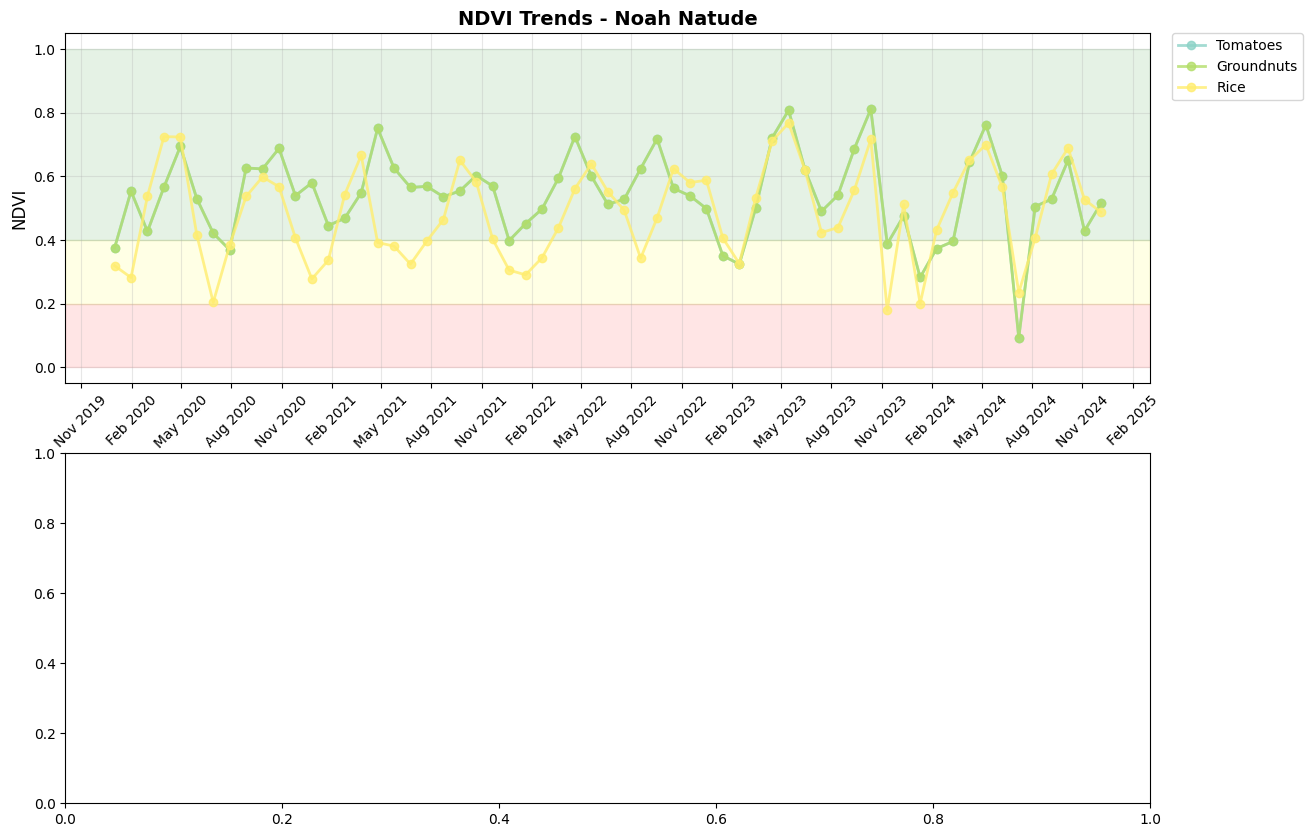

In [ ]:
# Cell 7: Practical Usage Examples

# Example 1: Run analysis and display results
print("EXAMPLE 1: Run Analysis and Display Results")
print("=" * 80)

# Run comprehensive analysis
current_df, historical_df, current_file, historical_file = get_comprehensive_farm_analysis(
    farmer_name="Noah Natude",
    start_date="2024-12-01",
    end_date="2025-01-30",
    include_historical=True,
    step_days=30
)

# Display current analysis
if not current_df.empty:
    display_current_analysis(current_df, farmer_name="Noah Natude", show_all=False)

    # Show all columns in a separate view
    print("\n" + "="*80)
    print("📋 FULL DETAILED VIEW:")
    print("="*80)
    display_current_analysis(current_df, farmer_name="Noah Natude", show_all=True)

    # Save report
    report_file = save_and_display_report(current_df, "Noah_Natude_Report")

    # Optionally download in Colab
    try:
        from google.colab import files
        print("\n📥 Click to download the report:")
        files.download(report_file)
    except:
        pass

# Display historical analysis
if historical_df is not None and not historical_df.empty:
    display_historical_analysis(historical_df, farmer_name="Noah Natude", show_plot=True)

    # Save historical report
    hist_report_file = save_and_display_report(historical_df, "Noah_Natude_Historical")

# Example 2: Analyze multiple farmers and compare
print("\n\n" + "="*80)
print("EXAMPLE 2: Compare Multiple Farmers")
print("="*80)

farmers_to_analyze = ["Noah Natude", "George Mukama", "Tukule Samuel"]
all_farmers_data = {}

for farmer in farmers_to_analyze:
    print(f"\n🔍 Analyzing {farmer}...")
    current_df, _, _, _ = get_comprehensive_farm_analysis(
        farmer_name=farmer,
        start_date="2024-12-01",
        end_date="2025-01-30",
        include_historical=False
    )

    if not current_df.empty:
        all_farmers_data[farmer] = current_df
        print(f"✅ {farmer}: {len(current_df)} parcels analyzed")

# Display comparison table
if all_farmers_data:
    display_comparison_table(all_farmers_data)

    # Create combined report
    combined_df = pd.concat(all_farmers_data.values(), ignore_index=True)
    combined_file = save_and_display_report(combined_df, "Combined_Farmers_Analysis")

# Example 3: Interactive DataFrame exploration
print("\n\n" + "="*80)
print("EXAMPLE 3: Interactive Data Exploration")
print("="*80)

if not current_df.empty:
    # Show DataFrame info
    print("📊 DATAFRAME INFO:")
    print("-" * 40)
    print(f"Shape: {current_df.shape}")
    print(f"Columns: {list(current_df.columns)}")
    print(f"Memory usage: {current_df.memory_usage(deep=True).sum() / 1024:.1f} KB")

    # Show data types
    print("\n📋 DATA TYPES:")
    print("-" * 40)
    print(current_df.dtypes.to_string())

    # Show descriptive statistics
    print("\n📈 DESCRIPTIVE STATISTICS:")
    print("-" * 40)
    numeric_cols = current_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(current_df[numeric_cols].describe().round(3).to_string())

    # Show unique values for categorical columns
    print("\n📋 CATEGORICAL VALUES:")
    print("-" * 40)
    categorical_cols = ['Crops', 'Rainfall_Status', 'Soil_Moisture_Status', 'Disease_Pest_Risk']
    for col in categorical_cols:
        if col in current_df.columns:
            unique_vals = current_df[col].unique()
            print(f"{col}: {len(unique_vals)} unique values")
            if len(unique_vals) <= 10:
                print(f"  {', '.join(map(str, unique_vals))}")

    # Interactive filtering example
    print("\n🔍 INTERACTIVE FILTERING EXAMPLES:")
    print("-" * 40)

    # Filter by risk level
    if 'Disease_Pest_Risk' in current_df.columns:
        high_risk = current_df[current_df['Disease_Pest_Risk'].str.contains('HIGH', na=False)]
        if not high_risk.empty:
            print(f"⚠️ High Risk Parcels ({len(high_risk)}):")
            print(high_risk[['Parcel_ID', 'Crops', 'Disease_Pest_Risk']].to_string(index=False))

    # Filter by NDVI health
    if 'NDVI' in current_df.columns:
        healthy = current_df[current_df['NDVI'] > 0.5]
        moderate = current_df[(current_df['NDVI'] > 0.3) & (current_df['NDVI'] <= 0.5)]
        poor = current_df[current_df['NDVI'] <= 0.3]

        print(f"\n🌱 Health Classification by NDVI:")
        print(f"  Healthy (NDVI > 0.5): {len(healthy)} parcels")
        print(f"  Moderate (0.3 < NDVI ≤ 0.5): {len(moderate)} parcels")
        print(f"  Poor (NDVI ≤ 0.3): {len(poor)} parcels")

# Example 4: Export to different formats
print("\n\n" + "="*80)
print("EXAMPLE 4: Export Options")
print("="*80)

if not current_df.empty:
    # Export to different formats
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

    # 1. CSV
    csv_file = f"Farm_Analysis_CSV_{timestamp}.csv"
    current_df.to_csv(csv_file, index=False)
    print(f"✅ CSV exported: {csv_file}")

    # 2. Excel (requires openpyxl)
    try:
        excel_file = f"Farm_Analysis_Excel_{timestamp}.xlsx"
        current_df.to_excel(excel_file, index=False, sheet_name='Farm Analysis')
        print(f"✅ Excel exported: {excel_file}")
    except Exception as e:
        print(f"Note: Excel export requires openpyxl. Install with: pip install openpyxl")

    # 3. JSON
    json_file = f"Farm_Analysis_JSON_{timestamp}.json"
    current_df.to_json(json_file, orient='records', indent=2)
    print(f"✅ JSON exported: {json_file}")

    # 4. HTML report
    html_file = f"Farm_Analysis_HTML_{timestamp}.html"
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Farm Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            h1 {{ color: #2c3e50; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
            th {{ background-color: #4CAF50; color: white; }}
            tr:nth-child(even) {{ background-color: #f2f2f2; }}
            .good {{ color: green; font-weight: bold; }}
            .warning {{ color: orange; font-weight: bold; }}
            .danger {{ color: red; font-weight: bold; }}
        </style>
    </head>
    <body>
        <h1>🌱 Farm Analysis Report</h1>
        <p>Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        <p>Farmer: Noah Natude</p>
        <p>Period: 2024-12-01 to 2025-01-30</p>

        {current_df.to_html(index=False, classes='dataframe')}

        <script>
            // Add color coding based on status
            document.querySelectorAll('td').forEach(cell => {{
                if (cell.textContent.includes('🚨') || cell.textContent.includes('🔴')) {{
                    cell.classList.add('danger');
                }} else if (cell.textContent.includes('⚠️') || cell.textContent.includes('🟠')) {{
                    cell.classList.add('warning');
                }} else if (cell.textContent.includes('✅') || cell.textContent.includes('🟢')) {{
                    cell.classList.add('good');
                }}
            }});
        </script>
    </body>
    </html>
    """

    with open(html_file, 'w', encoding='utf-8') as f:
        f.write(html_content)
    print(f"✅ HTML report exported: {html_file}")

print("\n" + "="*80)
print("🎉 DISPLAY FUNCTIONS READY TO USE!")
print("="*80)
print("\nAvailable functions:")
print("1. display_current_analysis(df, farmer_name, show_all)")
print("2. display_historical_analysis(df, farmer_name, show_plot)")
print("3. plot_historical_trends(df, farmer_name)")
print("4. display_comparison_table(farmers_data)")
print("5. save_and_display_report(df, filename_prefix)")